In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


In [5]:
data = yf.download(
    "RELIANCE.NS",
    start="2018-01-01",
    end="2026-01-01"
)

data = data[["Close"]]
data.dropna(inplace=True)

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price            Close
Ticker     RELIANCE.NS
Date                  
2018-01-01  401.864807
2018-01-02  402.483185
2018-01-03  404.095520
2018-01-04  406.525055
2018-01-05  407.828156


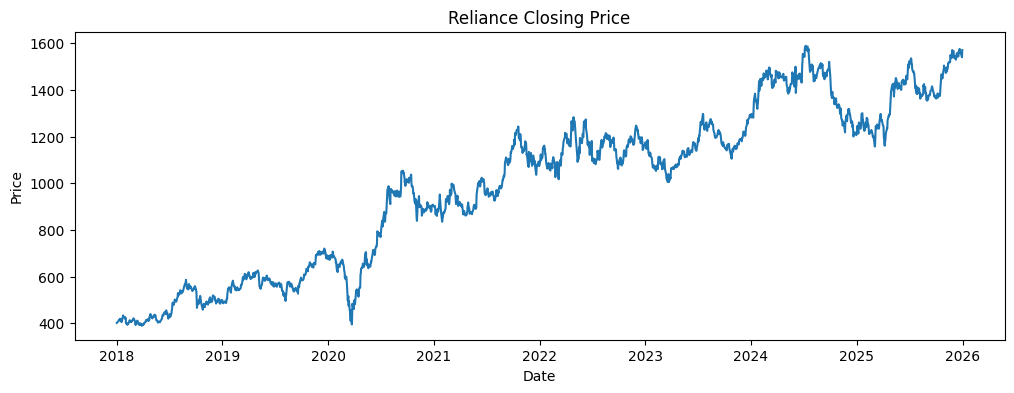

In [6]:
plt.figure(figsize=(12,4))
plt.plot(data["Close"])
plt.title("Reliance Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


### confirm non stationarity

In [8]:
price_diff = data["Close"].diff().dropna()

from statsmodels.tsa.stattools import adfuller
adf_stat, p_value, *_ = adfuller(price_diff)

print("ADF after differencing:", adf_stat)
print("p-value:", p_value)



ADF after differencing: -26.38495060608415
p-value: 0.0


### Plot ACF and PACF on differenced series

<Figure size 1200x400 with 0 Axes>

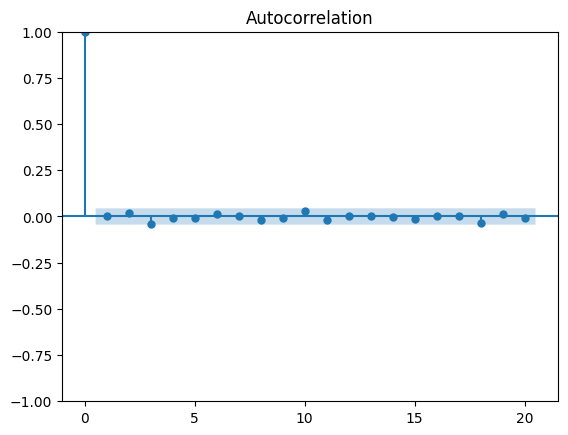

<Figure size 1200x400 with 0 Axes>

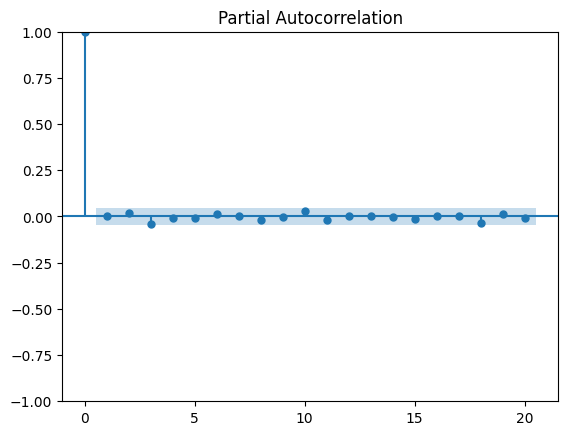

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

price_diff = data["Close"].diff().dropna()

plt.figure(figsize=(12,4))
plot_acf(price_diff, lags=20)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(price_diff, lags=20)
plt.show()


In [10]:
price_series = data["Close"]

train_size = int(len(price_series) * 0.8)
train_price = price_series[:train_size]
test_price = price_series[train_size:]


In [11]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(
    train_price,
    order=(1, 1, 1)
)

arima_fit = arima_model.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:            RELIANCE.NS   No. Observations:                 1582
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6539.688
Date:                Fri, 16 Jan 2026   AIC                          13085.377
Time:                        21:32:53   BIC                          13101.474
Sample:                             0   HQIC                         13091.358
                               - 1582                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2092      1.439      0.145      0.884      -2.611       3.029
ma.L1         -0.1960      1.441     -0.136      0.892      -3.021       2.629
sigma2       228.7586      4.686     48.820      0.0

/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autore

In [12]:
arima_forecast = arima_fit.forecast(steps=30)

arima_forecast = pd.Series(
    arima_forecast.values,
    index=pd.date_range(
        start=price_series.index[-1],
        periods=30,
        freq="B"
    )
)


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [15]:
forecast_steps = 30
forecast_values = arima_fit.forecast(steps=forecast_steps)

/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [17]:
forecast_steps = 30
forecast_values = arima_fit.forecast(steps=forecast_steps)

last_date = data.index[-1]

future_dates = pd.bdate_range(
    start=last_date + pd.offsets.BDay(1),
    periods=forecast_steps
)

arima_forecast = pd.Series(
    forecast_values.values,
    index=future_dates
)


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


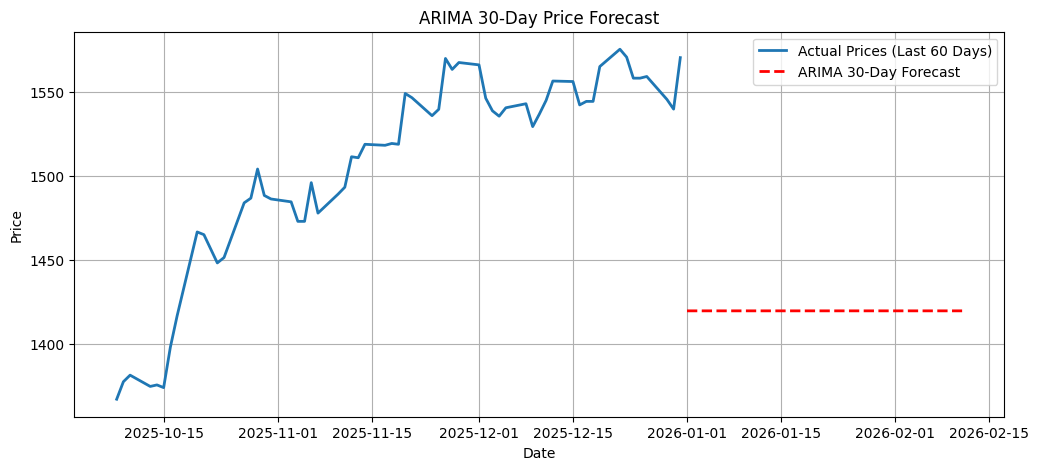

In [18]:
plt.figure(figsize=(12,5))

plt.plot(
    data["Close"].iloc[-60:],
    label="Actual Prices (Last 60 Days)",
    linewidth=2
)

plt.plot(
    arima_forecast,
    label="ARIMA 30-Day Forecast",
    linestyle="--",
    linewidth=2,
    color="red"
)

plt.title("ARIMA 30-Day Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
